<a href="https://colab.research.google.com/github/siddh1990/Data-Driven-Pump-it-Up/blob/main/DataDriven_Pump_it_up_Logistic_Regression_15_12_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_x=pd.read_csv("/content/Train set values.csv")
data_y=pd.read_csv("/content/Train set labels.csv")

In [ ]:
data=pd.merge(data_x,data_y,on="id",how="inner")

## Splitting the data into training and testing

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data_x,data_y,train_size=0.7,random_state=42,stratify=data_y["status_group"])

## Data Exploration

In [ ]:
#Numerical Features Description
x_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,41580.000000,41580.000000,41580.000000,41580.000000,4.158000e+04,41580.000000,41580.000000,41580.000000,41580.000000,41580.000000
mean,37053.095238,328.297768,670.883333,34.088923,-5.716324e+00,0.500000,15.198509,5.593218,180.270178,1303.064791
std,21379.253543,3380.560532,693.624472,6.541418,2.940352e+00,14.103926,17.463795,9.575067,462.724333,950.851187
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18530.750000,0.000000,0.000000,33.097738,-8.543252e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37055.500000,0.000000,374.000000,34.911885,-5.036156e+00,0.000000,12.000000,3.000000,27.500000,1986.000000
75%,55351.250000,25.000000,1322.000000,37.169114,-3.328690e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-2.000000e-08,1776.000000,99.000000,80.000000,15300.000000,2013.000000


In [ ]:
#Categorical Features Description
x_train.describe(include="O")

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,41580,39034,39025,41580,41580,41336,41580,41580,41580,39283,...,41580,41580,41580,41580,41580,41580,41580,41580,41580,41580
unique,346,1611,1802,27265,9,16078,21,124,2073,2,...,7,8,6,5,5,10,7,3,7,6
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Majengo,Iringa,Njombe,Igosi,True,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,410,6405,12204,2546,7058,364,3752,1769,222,35748,...,17792,35496,35496,23232,23232,11944,11944,32085,19911,24183


## Data Processing

In [ ]:
# making a copy of x_train and y_train. All processing will be done on the copies.

In [ ]:
x_train_3=x_train.copy()
y_train_3=y_train.copy()

In [ ]:
def process(a):
    #lat and long
    a["long_mod"]=a["longitude"]
    a.loc[a['long_mod'] == 0, 'long_mod'] = pd.NA
    grp_means=a.groupby(by=["region"])["long_mod"].transform("mean")
    a.long_mod=a.long_mod.fillna(grp_means)
    a["lat_mod"]=a["latitude"]
    a.loc[a['lat_mod'] <-100, 'lat_mod'] = pd.NA
    grp_means2=a.groupby(by=["region"])["lat_mod"].transform("mean")
    a.lat_mod=a.lat_mod.fillna(grp_means2)
    #gps_mod
    a["gps_height_mod"]=a["gps_height"]
    a.loc[a['gps_height_mod'] == 0, 'gps_height_mod'] = pd.NA
    grp_means3=a.groupby(by=["basin"])["gps_height_mod"].transform("mean")
    a.gps_height_mod=a.gps_height_mod.fillna(grp_means3)
    #date_recorded to days since last recorded
    a["date_recorded"]=pd.to_datetime(a["date_recorded"])
    a["dsr"]=pd.to_datetime("2023-11-16")-a["date_recorded"]
    a.dsr=(a.dsr/ pd.Timedelta(seconds=86400))
    #subvillage
    grp_mode4=a.groupby(by=["region"])["subvillage"].transform(lambda x: x.mode().iloc[0])
    a.subvillage=a.subvillage.fillna(grp_mode4)
    # funder and installer
    for i in ["funder","installer","wpt_name","subvillage","lga","ward"]:
        a[i]=a[i].str.lower()
        if i=="funder" or i=="installer":
            grp_mode=a.groupby(by=["region"])[i].transform(lambda x: x.mode().iloc[0])
            a[i]=a[i].fillna(grp_mode)
        minor_values=a[i].value_counts(dropna=False)[a[i].value_counts(dropna=False).values<=20].index
        a[i]=a[i].apply(lambda s:"minor" if s in minor_values else s)
    #amount_tsh
    a["amount_tsh_cat"] = a["amount_tsh"].apply(lambda x: 0 if x == 0 else 1)
    #population
    a.loc[a['population'] == 0, 'population'] = pd.NA
    grp_means3=a.groupby(by=["basin"])["population"].transform("mean")
    a.population=a.population.fillna(grp_means3)
    #construction_year
    a["const"]=a["construction_year"]
    a.loc[a["const"] == 0, "const"] = pd.NA
    grp_mode=a.groupby(by=["basin"])["const"].transform(lambda x: x.mode().iloc[0])
    a["const"]=a["const"].fillna(grp_mode)
    #scheme_management
    grp_mode=a.groupby(by=["region"])["scheme_management"].transform(lambda x: x.mode().iloc[0])
    a["scheme_management"]=a["scheme_management"].fillna(grp_mode)
    #permit
    grp_mode2=a.groupby(by=["region"])["permit"].transform(lambda x: x.mode().iloc[0])
    a["permit"]=a["permit"].fillna(grp_mode2)
    #public_meeting
    a["public_meeting"]=a["public_meeting"].fillna("True")
    a=a.drop(["id","num_private","region","recorded_by","scheme_name","extraction_type_group","extraction_type_class","management_group","payment_type","quality_group","source_type","source_class","waterpoint_type_group","amount_tsh","date_recorded","gps_height","latitude","longitude","quantity_group","construction_year"],axis=1)
    a[["region_code","district_code","const","amount_tsh_cat"]]= a[["region_code","district_code","const","amount_tsh_cat"]].astype("O")
    a[["public_meeting","permit"]]=a[["public_meeting","permit"]].astype("str")
    return a

In [ ]:
x_train_2=process(x_train_3)

In [ ]:
x_train_2.dtypes

funder                object
installer             object
wpt_name              object
basin                 object
subvillage            object
region_code           object
district_code         object
lga                   object
ward                  object
population           float64
public_meeting        object
scheme_management     object
permit                object
extraction_type       object
management            object
payment               object
water_quality         object
quantity              object
source                object
waterpoint_type       object
long_mod             float64
lat_mod              float64
gps_height_mod       float64
dsr                  float64
amount_tsh_cat        object
const                 object
dtype: object

In [ ]:
x_train_2.nunique()

funder                 207
installer              177
wpt_name                71
basin                    9
subvillage             128
region_code             27
district_code           20
lga                    124
ward                   737
population             955
public_meeting           2
scheme_management       12
permit                   2
extraction_type         18
management              12
payment                  7
water_quality            8
quantity                 5
source                  10
waterpoint_type          7
long_mod             40286
lat_mod              40283
gps_height_mod        2393
dsr                    346
amount_tsh_cat           2
const                   54
dtype: int64

In [ ]:
x_train_2.isna().sum()

funder               0
installer            0
wpt_name             0
basin                0
subvillage           0
region_code          0
district_code        0
lga                  0
ward                 0
population           0
public_meeting       0
scheme_management    0
permit               0
extraction_type      0
management           0
payment              0
water_quality        0
quantity             0
source               0
waterpoint_type      0
long_mod             0
lat_mod              0
gps_height_mod       0
dsr                  0
amount_tsh_cat       0
const                0
dtype: int64

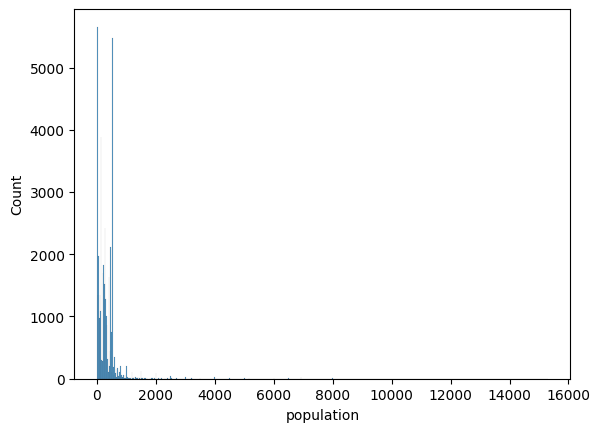

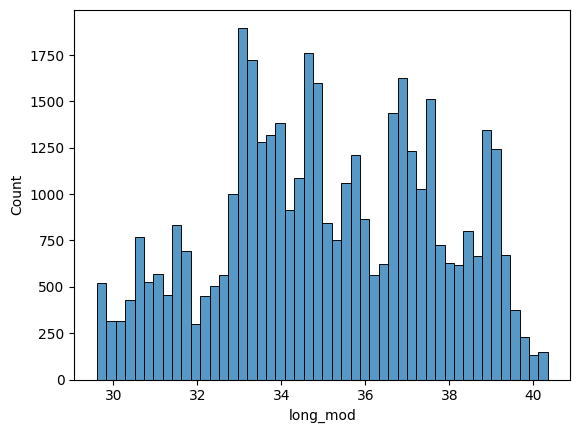

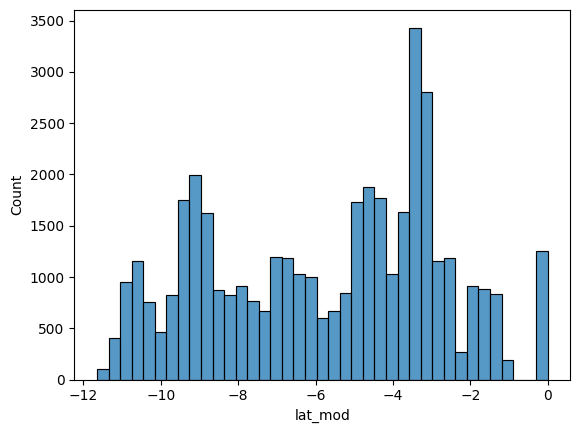

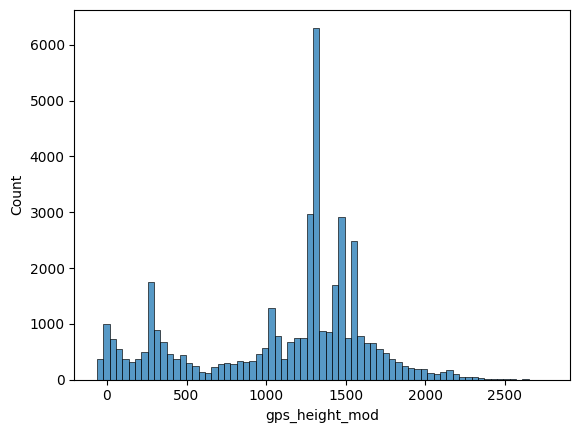

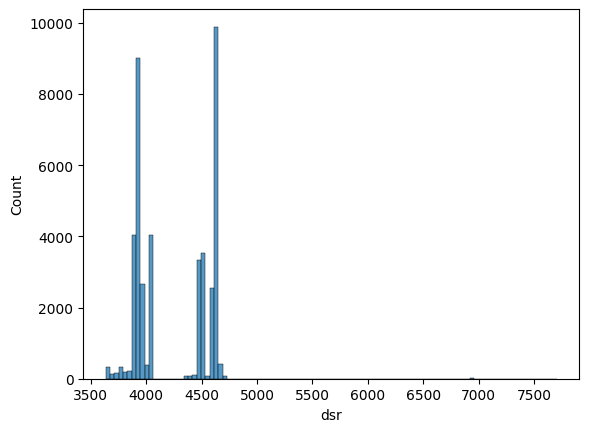

In [ ]:
num_col=x_train_2.select_dtypes(exclude="O").columns
for i in num_col:
    sns.histplot(x_train_2[i])
    plt.show()

In [ ]:
def scaling(a):
    from sklearn.preprocessing import StandardScaler
    num_col=a.select_dtypes(exclude="O").columns
    scaler=StandardScaler()
    scaler.fit(a[num_col])
    a[num_col]=scaler.transform(a[num_col])
    return a

In [ ]:
x_train_2=scaling(x_train_2)

In [ ]:
x_train_2[x_train_2.select_dtypes(exclude="O").columns]

,population,long_mod,lat_mod,gps_height_mod,dsr
5974,-0.258788,0.609716,0.803607,0.554559,-1.110585
31787,0.182065,-0.562773,1.216591,0.093798,-0.877739
27800,0.512705,0.682071,0.931303,0.136358,-1.047896
8008,0.469139,-0.800178,0.946356,0.408908,0.701434
39725,-0.697437,0.555711,0.014180,0.408374,-0.976251
...,...,...,...,...,...
21108,0.356520,-1.229784,0.797032,0.295293,-0.597130
14847,-0.567385,1.597075,-0.437328,-1.958345,1.196978
26579,-0.589428,1.457227,-0.363009,-1.871374,1.182052
8192,0.005724,1.647125,-1.675243,-1.266278,-0.943414


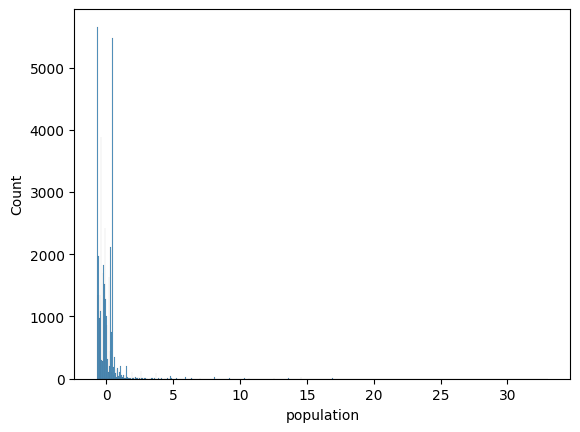

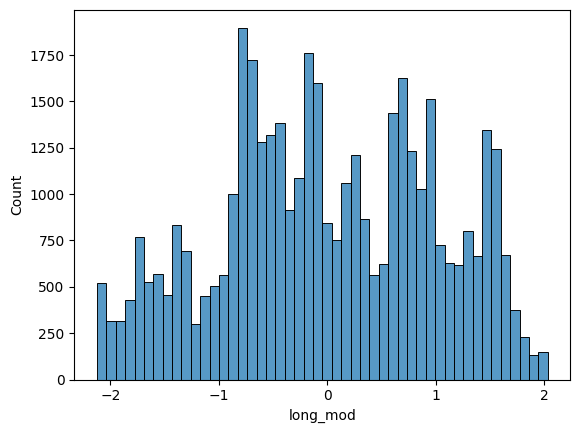

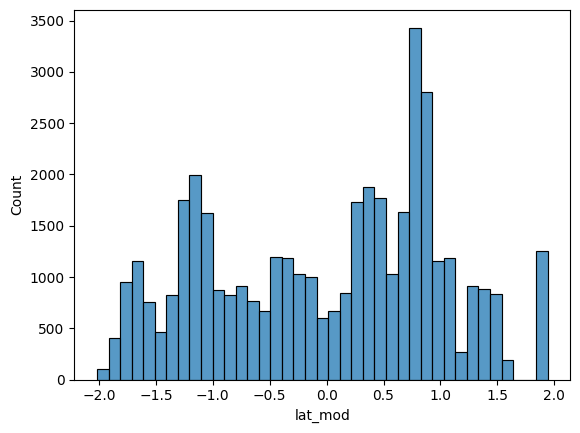

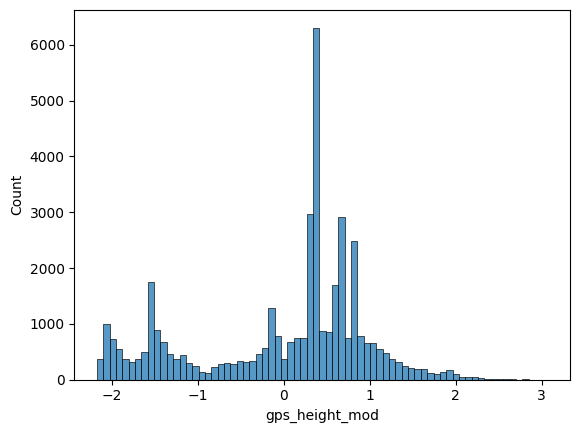

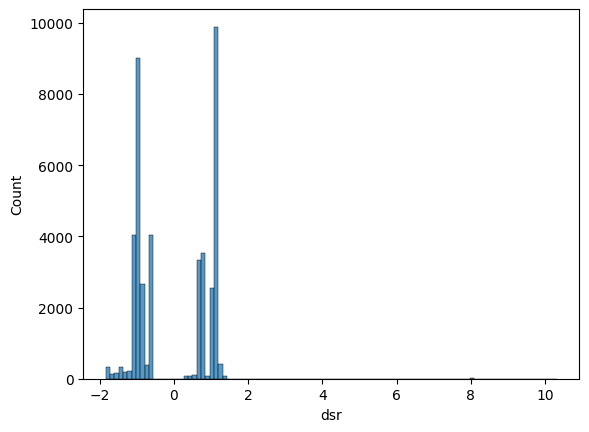

In [ ]:
num_col=x_train_2.select_dtypes(exclude="O").columns
for i in num_col:
    sns.histplot(x_train_2[i])
    plt.show()

In [ ]:
def transform(a):
    from sklearn.preprocessing import PowerTransformer
    pt = PowerTransformer()
    num_col=a.select_dtypes(exclude="O").columns
    pt.fit(a[num_col])
    a[num_col]=pt.transform(a[num_col])
    return a

In [ ]:
x_train_2=transform(x_train_2)

In [ ]:
x_train_2[x_train_2.select_dtypes(exclude="O").columns]

,population,long_mod,lat_mod,gps_height_mod,dsr
5974,-0.166057,0.600110,0.790402,0.466140,-1.143814
31787,0.686418,-0.574154,1.254668,-0.096709,-0.871928
27800,1.086940,0.674281,0.932267,-0.049373,-1.069946
8008,1.041474,-0.805754,0.949093,0.276590,0.744926
39725,-1.542336,0.544855,-0.045576,0.275914,-0.986121
...,...,...,...,...,...
21108,0.914717,-1.221198,0.783142,0.136026,-0.553869
14847,-1.074738,1.623985,-0.484936,-1.659232,1.177378
26579,-1.150359,1.477600,-0.414386,-1.608817,1.164683
8192,0.402347,1.676469,-1.591688,-1.231935,-0.947918


In [ ]:
x_train.nunique()

id                       41580
amount_tsh                  93
date_recorded              346
funder                    1611
gps_height                2385
installer                 1802
longitude                40285
latitude                 40283
wpt_name                 27265
num_private                 58
basin                        9
subvillage               16078
region                      21
region_code                 27
district_code               20
lga                        124
ward                      2073
population                 948
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2472
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [ ]:
x_train_2.isna().sum()

funder               0
installer            0
wpt_name             0
basin                0
subvillage           0
region_code          0
district_code        0
lga                  0
ward                 0
population           0
public_meeting       0
scheme_management    0
permit               0
extraction_type      0
management           0
payment              0
water_quality        0
quantity             0
source               0
waterpoint_type      0
long_mod             0
lat_mod              0
gps_height_mod       0
dsr                  0
amount_tsh_cat       0
const                0
dtype: int64

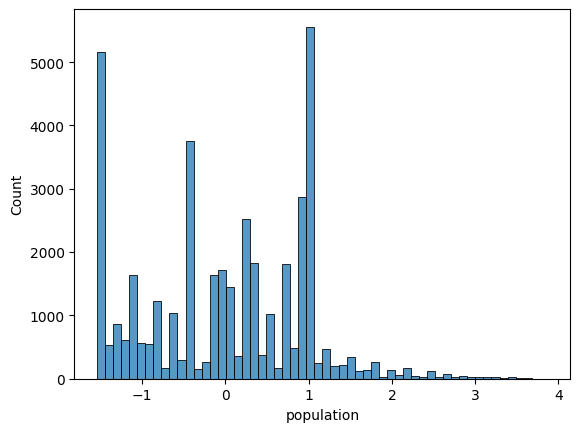

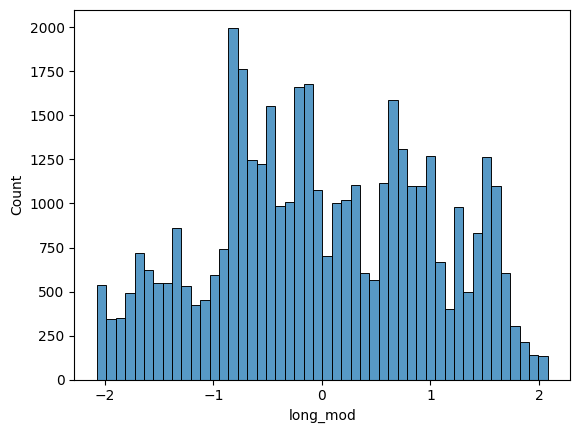

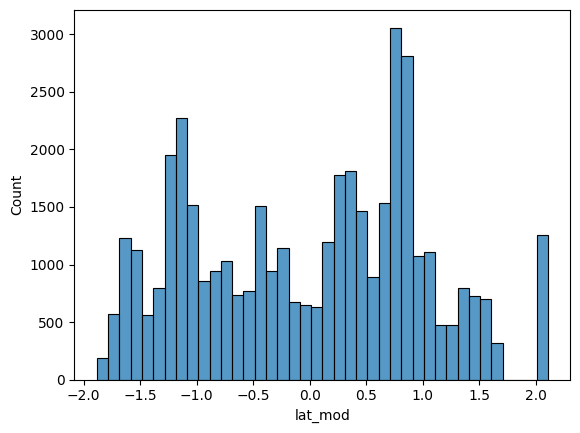

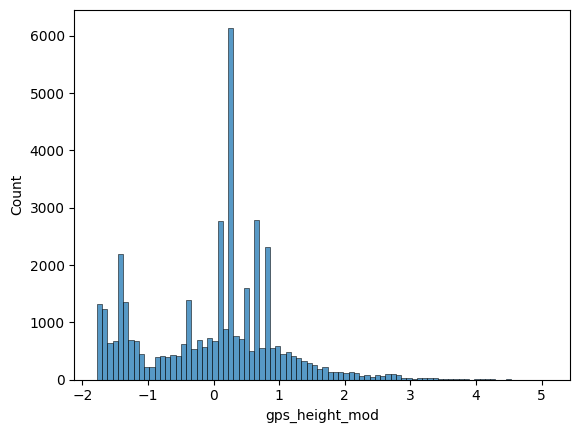

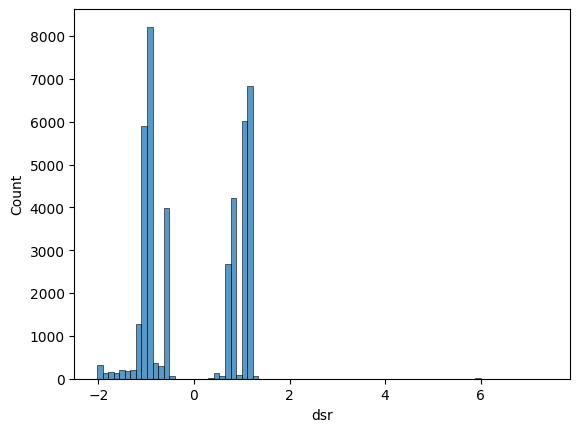

In [ ]:
num_col=x_train_2.select_dtypes(exclude="O").columns
for i in num_col:
    sns.histplot(x_train_2[i])
    plt.show()

In [ ]:
y_train_2=y_train.copy()

In [ ]:
y_train_2=y_train_2.drop("id",axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
Label_col=x_train_2.select_dtypes(include="O").columns
Or=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
Or.fit(x_train_2[Label_col])
x_train_2[Label_col]=Or.transform(x_train_2[Label_col])
#x_test_2[Label_col]=Or.transform(x_test_2[Label_col])

In [ ]:
le=LabelEncoder()
le.fit(y_train_2["status_group"])
y_train_2["status_group"]=le.transform(y_train_2["status_group"])
#y_test_2["status_group"]=le.transform(y_test_2["status_group"])

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR=LogisticRegression(class_weight="balanced",multi_class="ovr",max_iter=10000)

In [ ]:
LR.fit(x_train_2,y_train_2.values.ravel())

LogisticRegression(class_weight='balanced', max_iter=10000, multi_class='ovr')

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cv_scores = cross_val_score(LR, x_train_2, y_train_2.values.ravel(), cv=5, scoring="accuracy")

In [ ]:
cv_scores

array([0.56072631, 0.56204906, 0.56048581, 0.56914382, 0.56180856])

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters={"penalty":['l1', 'l2', 'elasticnet'],"C":[0.025,0.05,0.1,0.5],"solver":["newton-cg","sag","saga","lbfgs"],"class_weight":["balanced"]}
Grid=GridSearchCV(LR,param_grid=parameters,cv=5,scoring="f1_macro",n_jobs=-1)

In [ ]:
Grid.fit(x_train_2,y_train_2.values.ravel())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
140 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, multi_class='ovr'),
             n_jobs=-1,
             param_grid={'C': [0.025, 0.05, 0.1, 0.5],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             scoring='f1_macro')

In [ ]:
Grid.cv_results_

{'mean_fit_time': array([1.29833221e-02, 5.67417145e-03, 1.29940122e+02, 5.65433502e-03,
        4.29154181e+00, 6.27555268e+01, 1.06264740e+02, 3.12607643e+01,
        7.44624138e-03, 8.64672661e-03, 5.66645145e-02, 6.16245270e-03,
        5.45825958e-03, 6.62407875e-03, 1.34727676e+02, 6.80637360e-03,
        5.11764913e+00, 6.23032631e+01, 1.09079754e+02, 3.22003885e+01,
        1.05332851e-02, 7.66339302e-03, 4.75988865e-02, 8.56423378e-03,
        8.80532265e-03, 1.39680862e-02, 1.33849064e+02, 4.86831665e-03,
        4.86610441e+00, 7.08906629e+01, 1.07403061e+02, 3.11585692e+01,
        6.59341812e-03, 1.05792522e-02, 4.75751877e-02, 5.62119484e-03,
        7.69600868e-03, 1.20694160e-02, 1.36990541e+02, 4.89530563e-03,
        4.73972836e+00, 6.37091395e+01, 1.06736752e+02, 2.85133888e+01,
        5.55090904e-03, 5.75127602e-03, 2.97365189e-02, 5.88712692e-03]),
 'std_fit_time': array([4.45046880e-03, 5.53176656e-04, 5.23180192e+00, 1.74894857e-03,
        9.81511060e-01, 4.499

In [ ]:
Grid.best_score_

0.48706138907322993

In [ ]:
Grid.best_estimator_

LogisticRegression(C=0.05, class_weight='balanced', max_iter=10000,
                   multi_class='ovr')

In [ ]:
Grid.best_params_

{'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
def matrix(xtr,ytr,xte,yte,est):
    print ("\n Train accuracy",round(accuracy_score(ytr, est.predict(xtr)),3))
    print ("\n Train Classification Report\n\n", classification_report(ytr, est.predict(xtr)))
    print ("\n Test accuracy", round(accuracy_score(yte, est.predict(xte)),3))
    print ("\n Test Classification Report\n\n", classification_report(yte, est.predict(xte)))

In [ ]:
x_test_2=x_test.copy()
x_test_2=process(x_test_2)
x_test_2=scaling(x_test_2)
x_test_2=transform(x_test_2)
x_test_2[Label_col]=Or.transform(x_test_2[Label_col])
y_test_2=y_test.copy()
y_test_2["status_group"]=le.transform(y_test_2["status_group"])


In [ ]:
x_train_2.columns

In [ ]:
## Categorical features encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
Label_col=x_train_2.select_dtypes(include="O").columns
Or=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
Or.fit(x_train_2[Label_col])
x_train_2[Label_col]=Or.transform(x_train_2[Label_col])
x_test_2[Label_col]=Or.transform(x_test_2[Label_col])

In [ ]:
le=LabelEncoder()
le.fit(y_train_2["status_group"])
y_train_2["status_group"]=le.transform(y_train_2["status_group"])
y_test_2["status_group"]=le.transform(y_test_2["status_group"])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
def matrix(xtr,ytr,xte,yte,est):
    print ("\n Train accuracy",round(accuracy_score(ytr, est.predict(xtr)),3))
    print ("\n Train Classification Report\n\n", classification_report(ytr, est.predict(xtr)))
    print ("\n Test accuracy", round(accuracy_score(yte, est.predict(xte)),3))
    print ("\n Test Classification Report\n\n", classification_report(yte, est.predict(xte)))

In [ ]:
LR1=LogisticRegression(class_weight="balanced",multi_class="ovr",max_iter=10000,C=0.05,penalty='l2', solver= 'lbfgs')

In [ ]:
LR1.fit(x_train_2,y_train_2.values.ravel())

LogisticRegression(C=0.05, class_weight='balanced', max_iter=10000,
                   multi_class='ovr')

In [ ]:
y_pred=LR1.predict(x_train_2)

In [ ]:
np.unique(y_pred)

array([0, 1, 2])

In [ ]:
report=classification_report(y_train_2, y_pred,output_dict=True)

In [ ]:
report=pd.DataFrame(report).T

In [ ]:
report

,precision,recall,f1-score,support
0,0.734050,0.535007,0.618920,22581.000000
1,0.158039,0.437459,0.232195,3022.000000
2,0.598914,0.628153,0.613185,15977.000000
accuracy,0.563709,0.563709,0.563709,0.563709
macro avg,0.497001,0.533540,0.488100,41580.000000
weighted avg,0.640261,0.563709,0.588609,41580.000000


In [ ]:
y_pred_test=LR1.predict(x_test_2)

In [ ]:
y_pred_test

array([2, 2, 0, ..., 2, 1, 2])

In [ ]:
report_test=classification_report(y_test_2["status_group"], y_pred_test,output_dict=True)

In [ ]:
report_test=pd.DataFrame(report_test).T

In [ ]:
report_test

,precision,recall,f1-score,support
0,0.727846,0.524489,0.609656,9678.000000
1,0.156668,0.425483,0.229011,1295.000000
2,0.591213,0.632832,0.611315,6847.000000
accuracy,0.558923,0.558923,0.558923,0.558923
macro avg,0.491909,0.527601,0.483327,17820.000000
weighted avg,0.633839,0.558923,0.582632,17820.000000


## lbfgs

In [ ]:
parameters={"penalty":['l2'],"C":[0.001,0.025,0.05,0.1,0.5],"solver":["lbfgs"],"class_weight":["balanced"]}
Grid=GridSearchCV(LR,param_grid=parameters,cv=5,scoring="f1_macro",n_jobs=-1)

In [ ]:
Grid.fit(x_train_2,y_train_2.values.ravel())

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, multi_class='ovr'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.025, 0.05, 0.1, 0.5],
                         'class_weight': ['balanced'], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='f1_macro')

In [ ]:
Grid.best_score_

0.48706138907322993

In [ ]:
Grid.best_params_

{'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

"newton-cg","sag","saga","lbfgs"
##"newton-cg"

In [ ]:
parameters={"penalty":['l2'],"C":[0.001,0.025,0.05,0.1,0.5],"solver":["newton-cg"],"class_weight":["balanced"]}
Grid=GridSearchCV(LR,param_grid=parameters,cv=5,scoring="f1_macro",n_jobs=-1)

In [ ]:
Grid.fit(x_train_2,y_train_2.values.ravel())

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, multi_class='ovr'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.025, 0.05, 0.1, 0.5],
                         'class_weight': ['balanced'], 'penalty': ['l2'],
                         'solver': ['newton-cg']},
             scoring='f1_macro')

In [ ]:
Grid.best_score_

0.48691298525596494

In [ ]:
Grid.best_params_

{'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}

## sag

In [ ]:
parameters={"penalty":['l2'],"C":[0.001,0.025,0.05,0.1,0.5],"solver":["sag"],"class_weight":["balanced"]}
Grid=GridSearchCV(LR,param_grid=parameters,cv=5,scoring="f1_macro",n_jobs=-1)

In [ ]:
Grid.fit(x_train_2,y_train_2.values.ravel())

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, multi_class='ovr'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.025, 0.05, 0.1, 0.5],
                         'class_weight': ['balanced'], 'penalty': ['l2'],
                         'solver': ['sag']},
             scoring='f1_macro')

In [ ]:
Grid.best_score_

0.48110626768631065

In [ ]:
Grid.best_params_

{'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}

## saga

In [ ]:
parameters={"penalty":['elasticnet','l1', 'l2'],"C":[0.001,0.025,0.05,0.1,0.5],"solver":["saga"],"class_weight":["balanced"]}
Grid=GridSearchCV(LR,param_grid=parameters,cv=5,scoring="f1_macro",n_jobs=-1)

In [96]:
Grid.fit(x_train_2,y_train_2.values.ravel())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iter

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, multi_class='ovr'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.025, 0.05, 0.1, 0.5],
                         'class_weight': ['balanced'],
                         'penalty': ['elasticnet', 'l1', 'l2'],
                         'solver': ['saga']},
             scoring='f1_macro')

In [97]:
Grid.best_score_

0.4808965142352135

In [98]:
Grid.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

## Final Logistic Regression Model

In [ ]:
parameters={"penalty":['l2'],"C":[0.001,0.025,0.05,0.1,0.5],"solver":["lbfgs"],"class_weight":["balanced"]}

In [99]:
LR2= LogisticRegression(penalty="l2",C=0.05,solver="lbfgs",class_weight="balanced",multi_class="ovr",max_iter=10000)

In [100]:
cv_scores = cross_val_score(LR2, x_train_2, y_train_2.values.ravel(), cv=5, scoring="accuracy")

In [101]:
cv_scores

array([0.56120731, 0.56216931, 0.56216931, 0.56902357, 0.56120731])

In [102]:
np.mean(cv_scores)

0.5631553631553631

In [104]:
LR2.fit(x_train_2,y_train_2.values.ravel())

LogisticRegression(C=0.05, class_weight='balanced', max_iter=10000,
                   multi_class='ovr')

In [105]:
y_pred_test=LR2.predict(x_test_2)

In [106]:
report2=classification_report(y_train_2, y_pred,output_dict=True)

In [107]:
report2=pd.DataFrame(report2).T

In [108]:
report2

,precision,recall,f1-score,support
0,0.734050,0.535007,0.618920,22581.000000
1,0.158039,0.437459,0.232195,3022.000000
2,0.598914,0.628153,0.613185,15977.000000
accuracy,0.563709,0.563709,0.563709,0.563709
macro avg,0.497001,0.533540,0.488100,41580.000000
weighted avg,0.640261,0.563709,0.588609,41580.000000


In [122]:
LR2.coef_

array([[ 9.28361981e-04,  1.56577042e-03, -3.61550209e-04,
        -4.49141042e-02,  9.93202780e-04, -6.86230021e-03,
        -7.96006467e-03, -5.18506504e-04, -1.22455090e-04,
         1.09065449e-01,  2.60325749e-01, -2.28179327e-02,
         1.92558795e-02, -9.73269208e-03,  4.89993848e-02,
         3.06605339e-02, -7.76272610e-02,  3.17611685e-01,
         9.68726386e-02, -1.61857865e-01,  2.68682953e-01,
        -4.75346823e-02,  3.68165002e-01,  1.35329629e-01,
         1.06115184e+00,  4.28689552e-02],
       [ 4.22758466e-04,  1.59467897e-03,  1.09538683e-03,
         1.89250099e-02, -1.45129302e-03,  1.42422129e-02,
        -4.49461535e-02, -2.72043134e-03,  2.54532130e-04,
         2.43882303e-02, -2.49260771e-01,  3.53819903e-02,
        -1.82621182e-01, -2.60828243e-02,  4.25527949e-02,
        -7.76974023e-02, -2.40165814e-02,  4.19957367e-01,
         8.71878582e-02, -1.83627420e-01, -4.11654385e-01,
         5.42046558e-02, -2.62289379e-01, -1.64046768e-01,
         2.30

##lbfgs further hypertuning

In [118]:
parameters={"penalty":['l2'],"C":[0.001,0.025,0.05,0.1,0.5],"solver":["lbfgs"],"class_weight":["balanced"],"tol":[0.0001,0.001,0.01,0.1],"fit_intercept":[True,False]}
Grid=GridSearchCV(LR,param_grid=parameters,cv=5,scoring="f1_macro",n_jobs=-1)

In [119]:
Grid.fit(x_train_2,y_train_2)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, multi_class='ovr'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.025, 0.05, 0.1, 0.5],
                         'class_weight': ['balanced'],
                         'fit_intercept': [True, False], 'penalty': ['l2'],
                         'solver': ['lbfgs'],
                         'tol': [0.0001, 0.001, 0.01, 0.1]},
             scoring='f1_macro')

In [120]:
Grid.best_score_

0.48706138907322993

In [121]:
Grid.best_params_

{'C': 0.05,
 'class_weight': 'balanced',
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 0.0001}